In [1]:
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, ReLU, Concatenate, Layer
from tensorflow.keras.layers import Conv1D, MaxPool1D, GlobalAveragePooling1D, GlobalMaxPool1D, Flatten
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, Sequential
from extra_keras_metrics import get_complete_binary_metrics
from tensorflow import keras
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import pandas as pd
from retrieve_preprocessed_dataset import *

#### Retrieve dataset

In [32]:
epigenomes, labels, sequences = retrieve_preprocessed_dataset()

#### Retrieve sequence

In [8]:
from ucsc_genomes_downloader import Genome
genome = Genome("hg38")

Loading chromosomes for genome hg38:   0%|                                                      | 0/25 [00:00<…

In [9]:
def to_bed(data:pd.DataFrame)->pd.DataFrame:
    """Return bed coordinates from given dataset."""
    return data.reset_index()[data.index.names]

#### Retrieve baseline performance of FFNN, CNN

In [ ]:
df = pd.read_csv('./performance/all_performance_perc_ffnn_cnn.csv', index_col = [0])
all_base_classification_performance = df.loc[df['model_name'].isin(['FFNN'])]

In [2]:
X, y = np.arange(1000).reshape((500, 2)), np.arange(500)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [3]:
y = y>250

### Models

In [4]:
from typing import Dict, List, Tuple, Optional
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, ReLU, Concatenate, Layer
from tensorflow.keras.layers import Conv1D, MaxPool1D, GlobalAveragePooling1D, GlobalMaxPool1D, Flatten
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, Sequential
from extra_keras_metrics import get_complete_binary_metrics
from tensorflow import keras

In [5]:
# def build_perceptron(hp) -> Model:
        
#     input_layer = Input(shape = (2,))
#     output = Dense(1, activation = "sigmoid")

#     model = Sequential([
#         input_layer,
#         output
#     ])
    
#     model._name = 'tuned_perc'
        
#     lr = hp.Choice("learning_rate", values = [1e-1, 1e-2, 1e-3])
#     opt = tf.keras.optimizers.Adam(learning_rate=lr)

#     model.compile(
#         optimizer = opt,
#         loss = "binary_crossentropy",
#         metrics = get_complete_binary_metrics()
#     )
    
#     return model

In [19]:
def build_ffnn(hp):
    
    input_layer = Input(shape = (2,))
    output = Dense(1, activation = "sigmoid")
    
    hp_units_1 = hp.Choice('units_1', [16, 32, 64, 128])
    hp_units_2 = hp.Choice('units_2', [4, 8, 16, 32])
    hp_units_3 = hp.Choice('units_3', [2, 4, 8])
    
    model = tf.keras.Sequential()
    model.add(input_layer)
    
    model.add(Dense(units = hp_units_1, activation = 'relu'))
    hp_dropout = hp.Float('drop_rate1', min_value = 0.0, max_value = 0.5, step = 0.1)
    model.add(Dropout(hp_dropout))
    
    model.add(Dense(units = hp_units_2, activation = 'relu'))
    hp_dropout = hp.Float('drop_rate2', min_value = 0.0, max_value = 0.5, step = 0.1)
    model.add(Dropout(hp_dropout))
    
    model.add(Dense(units = hp_units_3, activation = 'relu'))
    hp_dropout = hp.Float('drop_rate3', min_value = 0.0, max_value = 0.5, step = 0.1)
    model.add(Dropout(hp_dropout))
    
    model.add(output)

    model._name = 'tuned_FFNN'
    
    model.compile(
        optimizer = "SGD", 
        loss = "binary_crossentropy", 
        metrics = get_complete_binary_metrics())
    
    return model

In [6]:
# def build_ffnn(hp):
    
#     input_layer = Input(shape = (2,))
#     output = Dense(1, activation = "sigmoid")
    
#     model = tf.keras.Sequential()
#     model.add(input_layer)
    
#     for i in range(hp.Int('num_layers', 1, 2)):

#         hp_units = hp.Int('units_'+str(i), min_value=32, max_value=128, step=32)
#         model.add(Dense(units=hp_units, activation='relu'))

#         hp_dropout = hp.Float('rate', min_value = 0.0, max_value = 0.5, step = 0.1)
#         model.add(Dropout(hp_dropout))
        
#     model.add(output)  

#     model.compile(
#         optimizer="nadam",
#         loss="binary_crossentropy",
#         metrics=get_complete_binary_metrics()
#     )
    
#     model._name = 'tuned_FFNN'
    
#     return model

In [17]:
def build_CNN(hp):
    input_layer = Input(shape=(window_size, 4))
    output = Dense(1, activation="sigmoid")
    
    hp_units_1 = hp.Int('units_1', min_value = 64, max_value = 128, step = 32)
    hp_units_2 = hp.Int('units_2', min_value = 128, max_value = 256, step = 64)
    hp_units_3 = hp.Int('units_3', min_value = 10, max_value = 10, step = 40)
    
    model = tf.keras.Sequential()
    model.add(input_layer)
    
    model.add(Conv1D(units = hp_units_1, kernel_size = 5, activation = 'relu'))
    model.add(MaxPool1D(pool_size=2))
    
    model.add(Conv1D(units = hp_units_2, kernel_size = 3, activation = 'relu'))
    model.add(GlobalAveragePooling1D())
    
    hp_dropout = hp.Float('rate1', min_value = 0.0, max_value = 0.5, step = 0.1)
    model.add(Dropout(hp_dropout))
    
    model.add(Dense(units = hp_units_3, activation = 'relu'))
    
    hp_dropout = hp.Float('rate2', min_value = 0.0, max_value = 0.5, step = 0.1)
    model.add(Dropout(hp_dropout))
    
    model.add(output)
    
    
    model.compile(
        optimizer="nadam",
        loss="binary_crossentropy",
        metrics=get_complete_binary_metrics()
    )
    
    model._name = 'tuned_CNN'
    
    return model

In [ ]:
# def build_sequential_cnn(window_size: int):
   
#     input_sequence_data = Input(shape=(window_size, 4), name="sequence_data")
#     output =  Dense(1, activation="sigmoid")
    
#     model = Sequential([
#         input_sequence_data,
#         Conv1D(64, kernel_size=5, activation="relu"),
#         MaxPool1D(pool_size=2),
#         Conv1D(128, kernel_size=3, activation="relu"),
#         GlobalAveragePooling1D(),
#         Dropout(rate=0.5),
#         Dense(10, activation = 'relu'),
#         Dropout(rate=0.5),
#         output
#     ])
    
#     model._name = 'CNN'


#     model.compile(
#         optimizer="nadam",
#         loss="binary_crossentropy",
#         metrics=get_complete_binary_metrics()
#     )
#     return model

### Holdout generator

In [6]:
from sklearn.model_selection import StratifiedShuffleSplit, ShuffleSplit

# aumentare numero di splits (10)
number_of_splits = 2

holdouts_generator = StratifiedShuffleSplit(
    n_splits = number_of_splits,
    test_size = 0.2, 
    random_state = 300
)

### Get sequence

In [10]:
from keras_mixed_sequence import MixedSequence, VectorSequence
from keras_bed_sequence import BedSequence

def get_ffnn_sequence(X: np.ndarray, y: np.ndarray, batch_size: int = 128) -> MixedSequence:

    return MixedSequence(
        
        x =  VectorSequence(X, batch_size),
        
        y = VectorSequence(y, batch_size)
    )


def get_cnn_sequence(
    genome: Genome,
    bed: pd.DataFrame,
    y: np.ndarray,
    batch_size: int = 1024) -> MixedSequence:

    return MixedSequence(
        x={
            "sequence_data": BedSequence(
                genome,
                bed,
                batch_size=batch_size,
            )
        },
        y=VectorSequence(
            y,
            batch_size=batch_size
        )
    )

### Training

In [11]:
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
from typing import Tuple

def train_model(
    model: Model,
    model_name: str,
    task: str,
    train_sequence,
    test_sequence,
    holdout_number: int) -> Tuple[pd.DataFrame, pd.DataFrame]:

    history = pd.DataFrame(model.fit(
        train_sequence,
        validation_data = test_sequence,
        epochs = 10,
        batch_size = 10,
        verbose = False,
        callbacks = [EarlyStopping("loss", min_delta = 0.001, patience = 2, mode = "min"),]).history)
    
    train_evaluation = dict(zip(model.metrics_names, model.evaluate(train_sequence, verbose = False)))
    test_evaluation = dict(zip(model.metrics_names, model.evaluate(test_sequence, verbose = False)))
    train_evaluation["run_type"] = "train"
    test_evaluation["run_type"] = "test"
    
    for evaluation in (train_evaluation, test_evaluation):
        evaluation["model_name"] = model_name
        evaluation["task"] = task
        evaluation["holdout_number"] = holdout_number
    
    evaluations = pd.DataFrame([
        train_evaluation,
        test_evaluation
    ])
    
    return history, evaluations

### Tuning

In [12]:
import keras_tuner as kt

In [20]:
best_hyper =  {
    region: list()
    for region in ['promoters', 'enhancers']
}

best_models = []
all_binary_classification_performance = []

window_size = 256

for region in ['promoters', 'enhancers']:

    for holdout_index, (train_indices, test_indices) in enumerate(holdouts_generator.split(X, y)):

        X_train, X_test = X[train_indices], X[test_indices]
        y_train, y_test = y[train_indices], y[test_indices]

        y_train = y_train.flatten()
        y_test= y_test.flatten()

        X_subtrain, X_val, y_subtrain, y_val = train_test_split(
            X_train, y_train,
            test_size = 0.33, 
            random_state = 42)
        
        for model, build_model in zip(['ffnn'],[build_ffnn]):
            
            dir_name = 'bayesian_tuning_' +  model
            proj_name = region + "_holdout_" + str(holdout_index)
            
            tuner_bayesian = kt.BayesianOptimization(
                build_model,
                objective = "val_accuracy",
                max_trials = 5, 
                seed = 42,
                project_name = proj_name,
                directory = dir_name)

            tuner_bayesian.search(
                X_subtrain, 
                y_subtrain,
                epochs = 30, 
                validation_data = (X_val, y_val),
                callbacks = [EarlyStopping("val_loss", min_delta = 0.001, patience = 2, mode = "min")])

            best_hps = tuner_bayesian.get_best_hyperparameters()
            model = build_model(best_hps[0])

            best_hyper[region].append(best_hps)

            # EVALUATION OF THE BEST MODEL ON THE TEST SET

            train_sequence = get_ffnn_sequence(X_train, y_train)
            test_sequence = get_ffnn_sequence(X_test, y_test)

            history, performance = train_model(
                            model,
                            model.name,
                            task = region,
                            train_sequence = train_sequence,
                            test_sequence = test_sequence,
                            holdout_number = holdout_index
                        )

            all_binary_classification_performance.append(performance)

all_binary_classification_performance = pd.concat(all_binary_classification_performance)    

Trial 5 Complete [00h 00m 04s]
val_accuracy: 0.5075757503509521

Best val_accuracy So Far: 0.5151515007019043
Total elapsed time: 00h 00m 24s
INFO:tensorflow:Oracle triggered exit


In [25]:
best_hyper["promoters"][0][0].get('drop_rate1')

0.1

In [37]:
all_ffnn_classification_performance = pd.concat([all_binary_classification_performance, all_base_classification_performance ])   

In [38]:
all_ffnn_classification_performance

,loss,accuracy,recall,precision,AUROC,AUPRC,f1_score,balanced_accuracy,specificity,miss_rate,...,fowlkes_mallows_index,informedness,markedness,positive_likelyhood_ratio,negative_likelyhood_ratio,DOR,run_type,model_name,task,holdout_number
0,0.693172,0.497500,1.000000,0.497500,0.500000,0.497500,0.664441,0.500000,0.000000,0.000000,...,0.500000,0.705337,-0.502500,1.000000,0.000000,1.000000,train,tuned_FFNN,promoters,0
1,0.693154,0.500000,1.000000,0.500000,0.500000,0.500000,0.666667,0.500000,0.000000,0.000000,...,0.500000,0.707107,-0.500000,1.000000,0.000000,1.000000,test,tuned_FFNN,promoters,0
0,0.693150,0.497500,1.000000,0.497500,0.500000,0.497500,0.664441,0.500000,0.000000,0.000000,...,0.500000,0.705337,-0.502500,1.000000,0.000000,1.000000,train,tuned_FFNN,promoters,1
1,0.693147,0.500000,1.000000,0.500000,0.500000,0.500000,0.666667,0.500000,0.000000,0.000000,...,0.500000,0.707107,-0.500000,1.000000,0.000000,1.000000,test,tuned_FFNN,promoters,1
0,0.693144,0.502500,0.000000,0.000000,0.500000,0.497500,0.000000,0.500000,1.000000,1.000000,...,0.500000,0.000000,-0.497500,0.000000,1.000000,1.000000,train,tuned_FFNN,promoters,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,0.209845,0.941139,0.020804,0.277778,0.700961,0.179591,0.038710,0.508768,0.996733,0.979196,...,0.508768,0.076020,0.221759,6.367031,0.982405,1.035700,test,FFNN,enhancers,12
0,0.515765,0.943075,0.000347,0.500000,0.500650,0.058495,0.000693,0.500163,0.999979,0.999653,...,0.500163,0.013172,0.443092,16.488241,0.999674,1.000652,train,FFNN,enhancers,13
1,0.515934,0.942877,0.000000,0.000000,0.500381,0.057260,0.000000,0.499916,0.999832,1.000000,...,0.499916,0.000000,-0.056974,0.000000,1.000167,0.999665,test,FFNN,enhancers,13
0,0.198079,0.943075,0.000000,0.000000,0.728927,0.195968,0.000000,0.500000,1.000000,1.000000,...,0.500000,0.000000,-0.056925,0.000000,1.000000,1.000000,train,FFNN,enhancers,14


### Plot trials

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt


def plot_trials(trial_index, params):    
    sns.set_theme(style="whitegrid")

    metrics_to_plot = ['accuracy', 'AUROC', 'AUPRC', 'balanced_accuracy']
    fig, axes = plt.subplots(1, 4, figsize  = (16, 2))

    for metr, ax in zip(metrics_to_plot, axes.flatten()):
        val_metric = f'val_{metr}'
        sns.barplot(x = "value", y="metrics",
                    data=df[(df.metrics == metr) | (df.metrics == val_metric)], 
                    alpha=0.9,
                    ax = ax)
        ax.set(xlabel = ' ', ylabel = ' ')

    plt.suptitle(f'Holdout 1 - trials {trial_index+1} {params}', fontsize=15)    
    plt.tight_layout()      

In [42]:
import json
f = open('./bayesian_tuning_perceptron/holdout_0/trial_0/trial.json')
  
# returns JSON object as 
# a dictionary
data = json.load(f)
params = data['hyperparameters']['values']

d = data['metrics']['metrics']
d = list(zip(d.keys(), [d[metric]['observations'][0]['value'][0] for metric in d.keys()]))

df = pd.DataFrame(d, columns = ['metrics', 'value'])

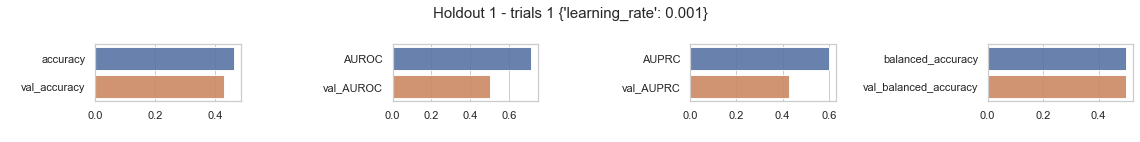

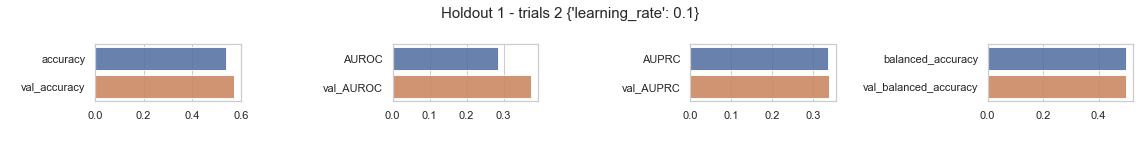

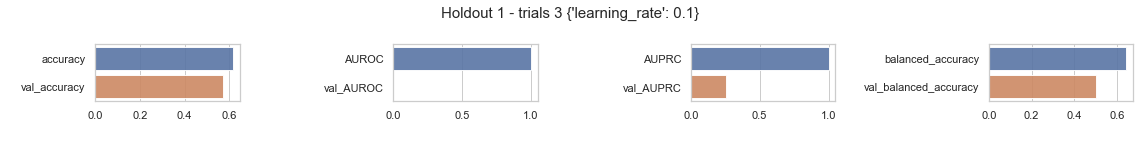

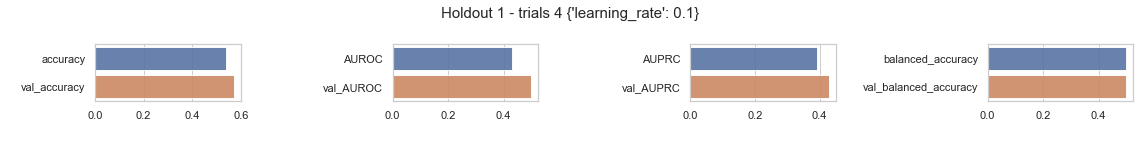

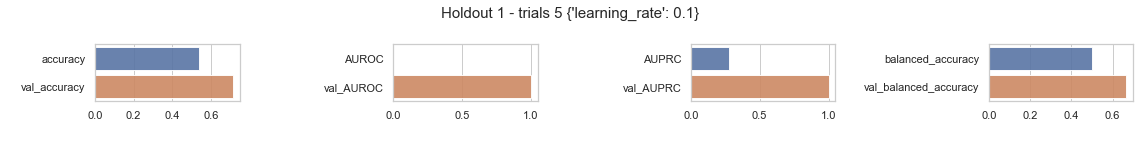

In [43]:
PATH_HOLDOUT = './bayesian_tuning_perceptron/holdout_2'

for trial_index in range(5):
    
    f = open(f'{PATH_HOLDOUT}/trial_{trial_index}/trial.json')
    
    data = json.load(f)
    
    # PER SAPERE GLI HYPERPARAMS USATI
    # print(data['hyperparameters']['values'])
    
    params = data['hyperparameters']['values']
    d = data['metrics']['metrics']
    d = list(zip(d.keys(), [d[metric]['observations'][0]['value'][0] for metric in d.keys()]))

    df = pd.DataFrame(d, columns = ['metrics', 'value'])
    
    plot_trials(trial_index, params)

### Plot check performance

Rendering barplots:   0%|                                                                       | 0/27 [00:00<…

((<Figure size 2000x300 with 2 Axes>,
  <Figure size 2000x300 with 2 Axes>,
  <Figure size 2000x300 with 2 Axes>,
  <Figure size 2000x300 with 2 Axes>,
  <Figure size 2000x300 with 2 Axes>,
  <Figure size 2000x300 with 2 Axes>,
  <Figure size 2000x300 with 2 Axes>,
  <Figure size 2000x300 with 2 Axes>,
  <Figure size 2000x300 with 2 Axes>,
  <Figure size 2000x300 with 2 Axes>,
  <Figure size 2000x300 with 2 Axes>,
  <Figure size 2000x300 with 2 Axes>,
  <Figure size 2000x300 with 2 Axes>,
  <Figure size 2000x300 with 2 Axes>,
  <Figure size 2000x300 with 2 Axes>,
  <Figure size 2000x300 with 2 Axes>,
  <Figure size 2000x300 with 2 Axes>,
  <Figure size 2000x300 with 2 Axes>,
  <Figure size 2000x300 with 2 Axes>,
  <Figure size 2000x300 with 2 Axes>,
  <Figure size 2000x300 with 2 Axes>,
  <Figure size 2000x300 with 2 Axes>,
  <Figure size 2000x300 with 2 Axes>,
  <Figure size 2000x300 with 2 Axes>,
  <Figure size 2000x300 with 2 Axes>,
  <Figure size 2000x300 with 2 Axes>,
  <Figure si

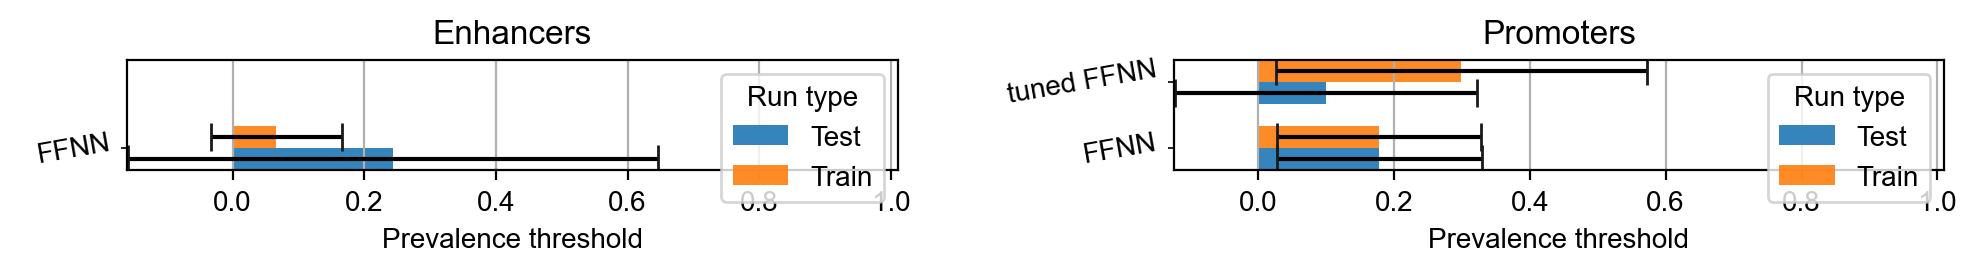

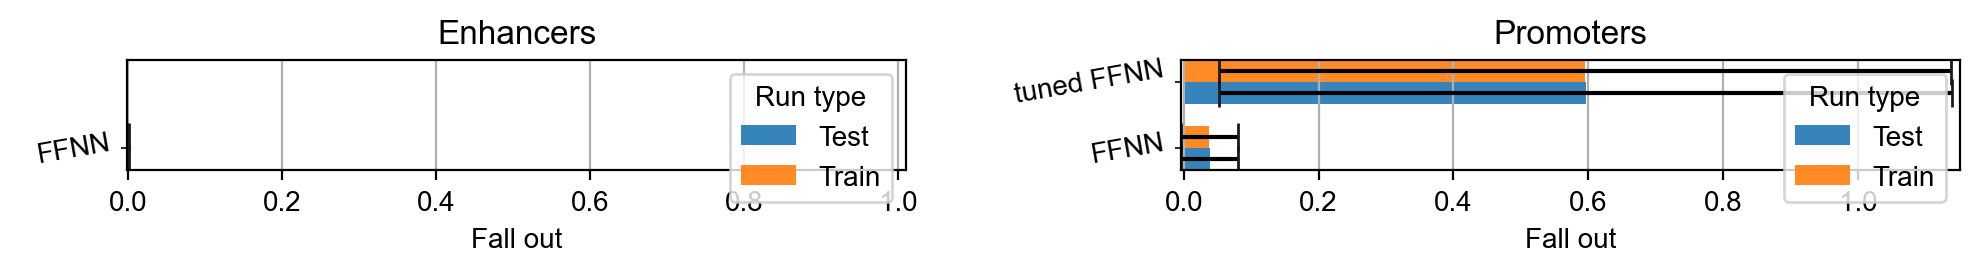

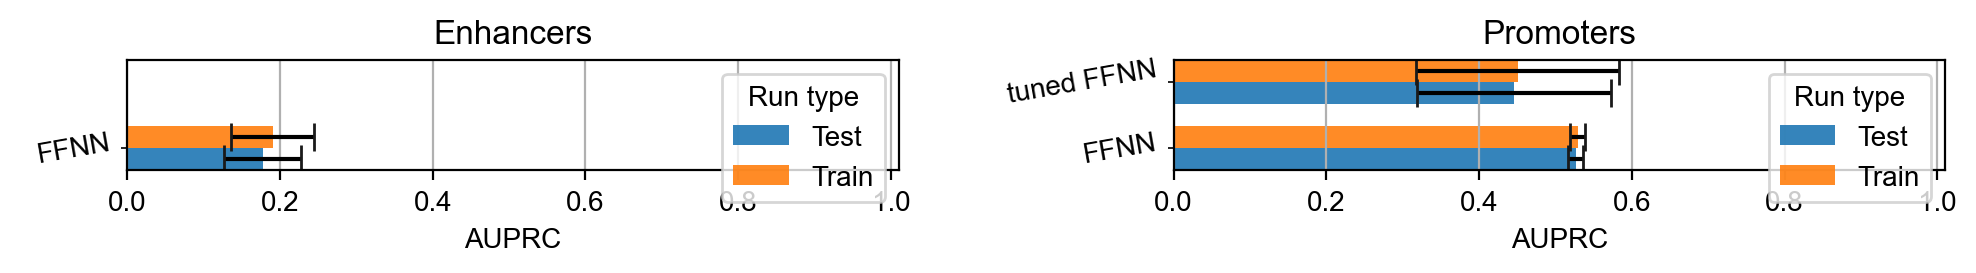

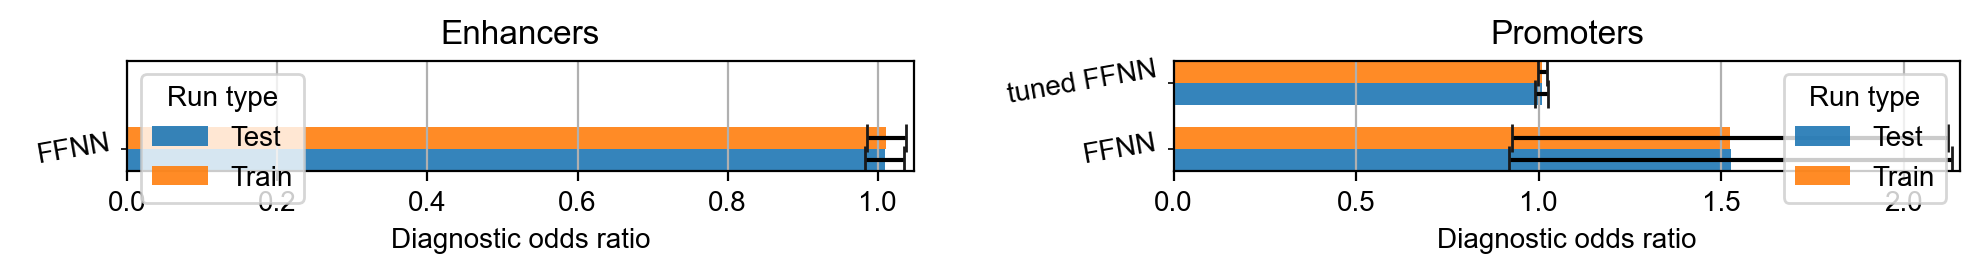

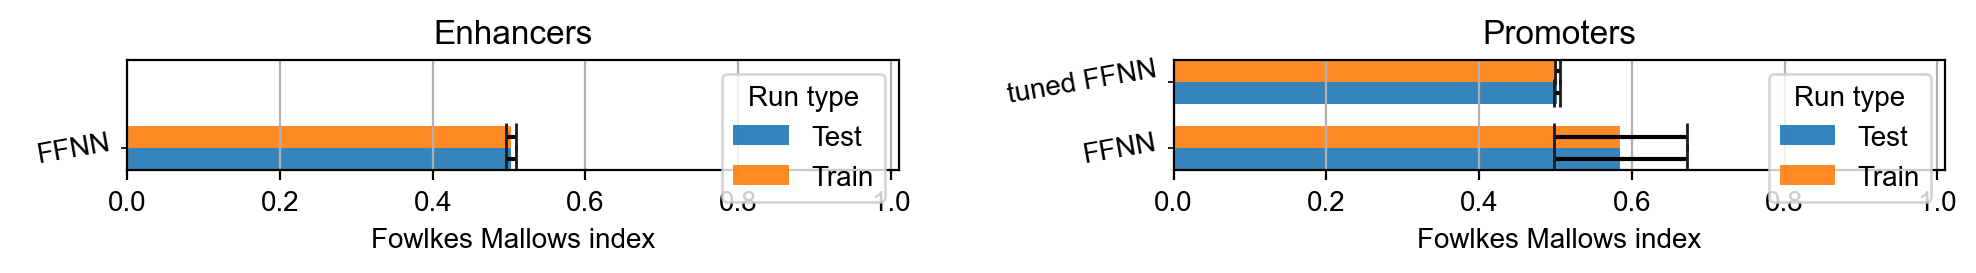

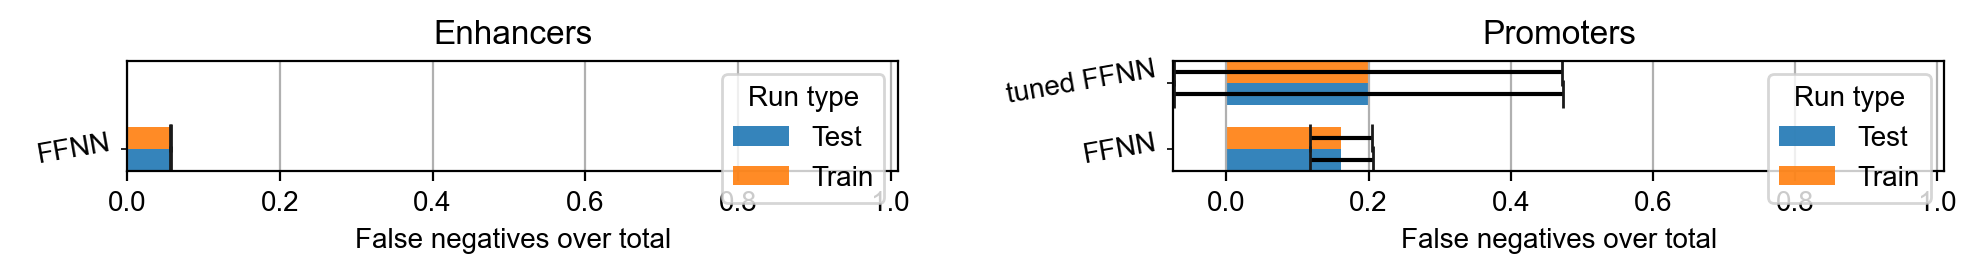

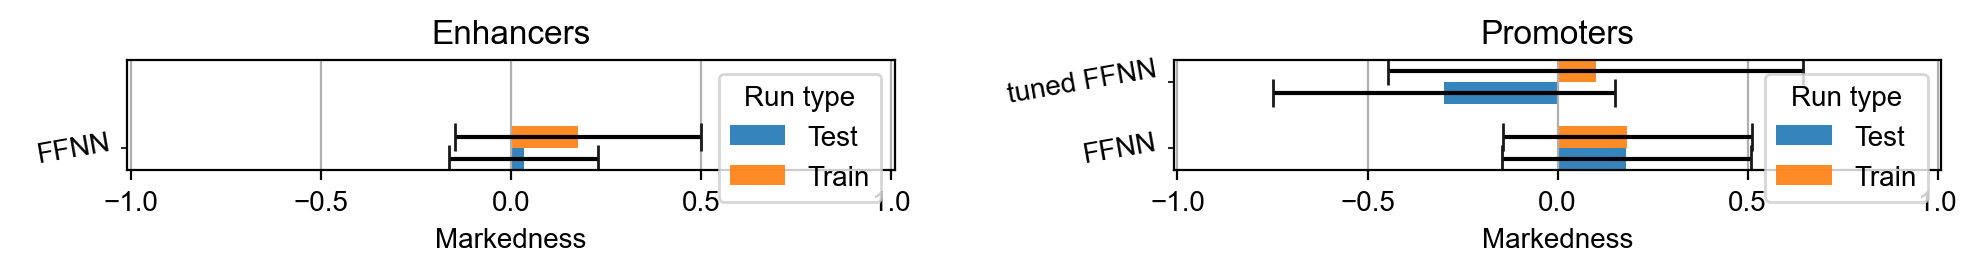

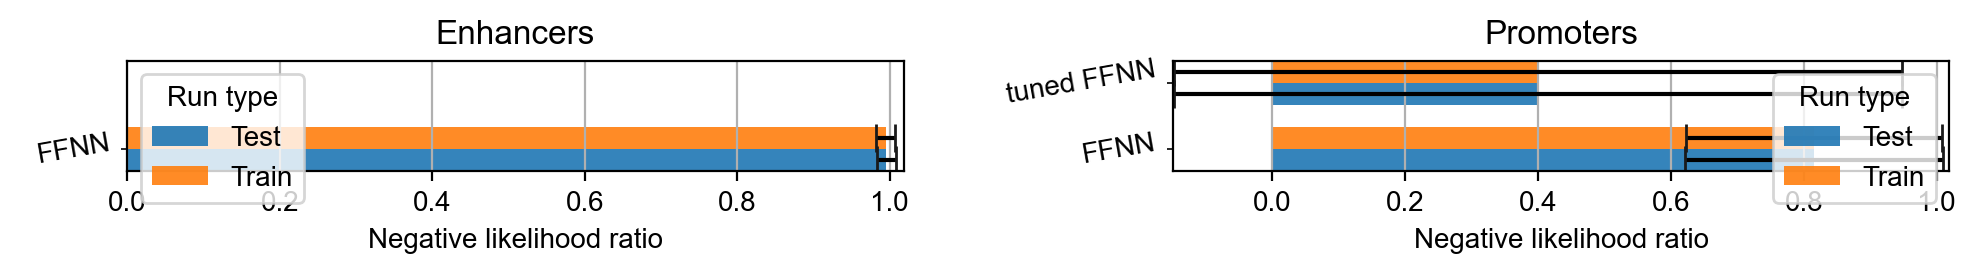

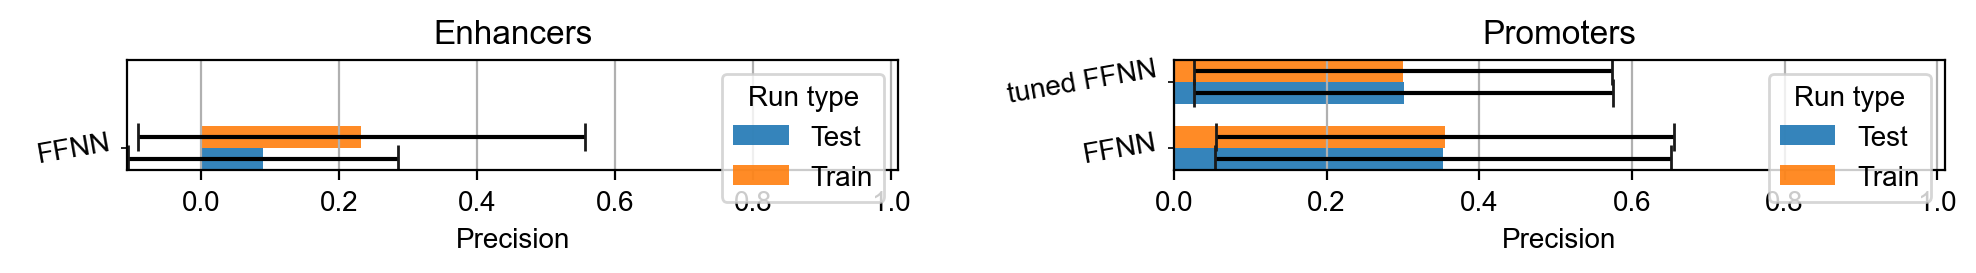

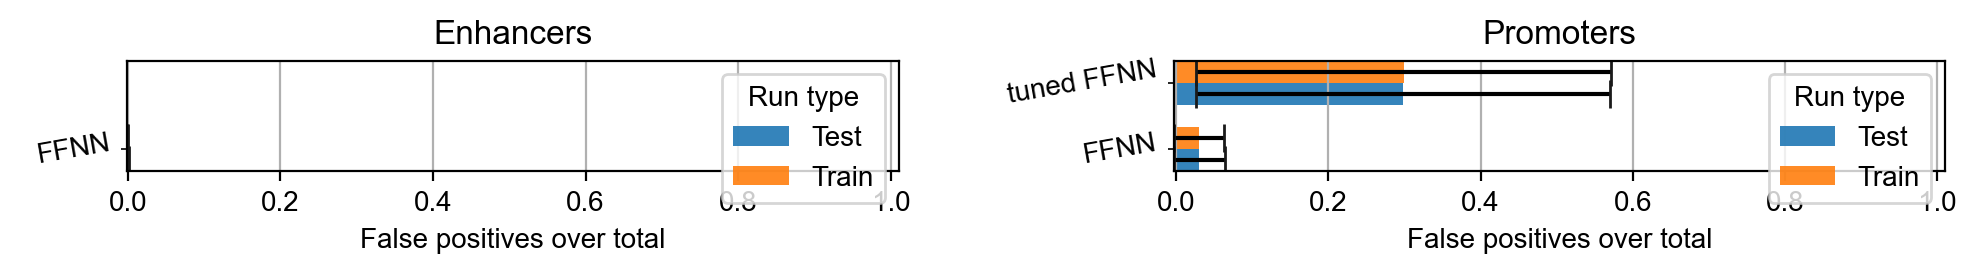

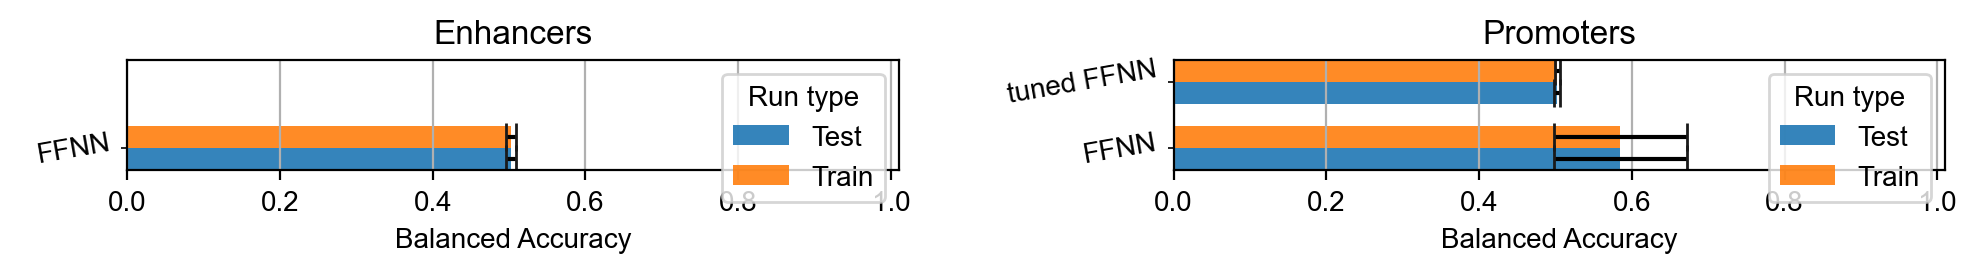

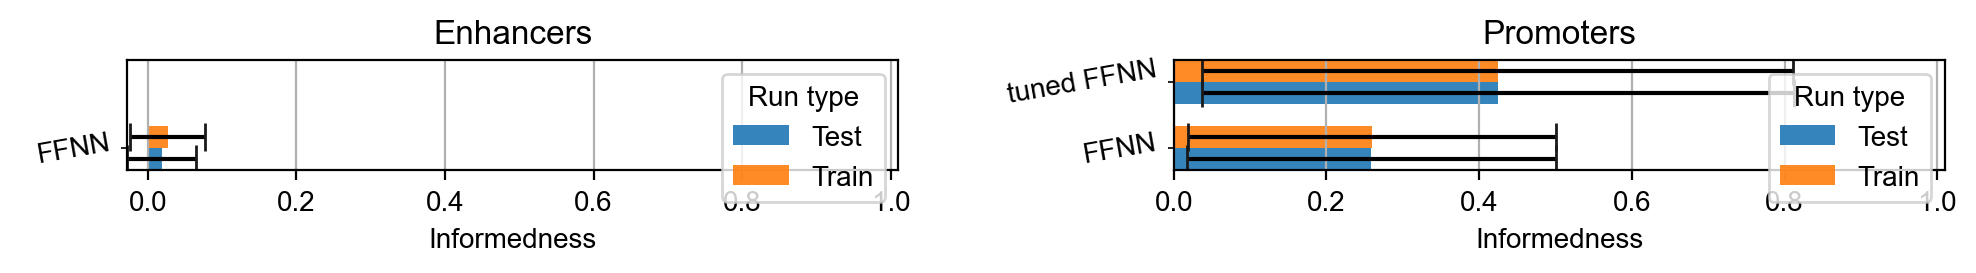

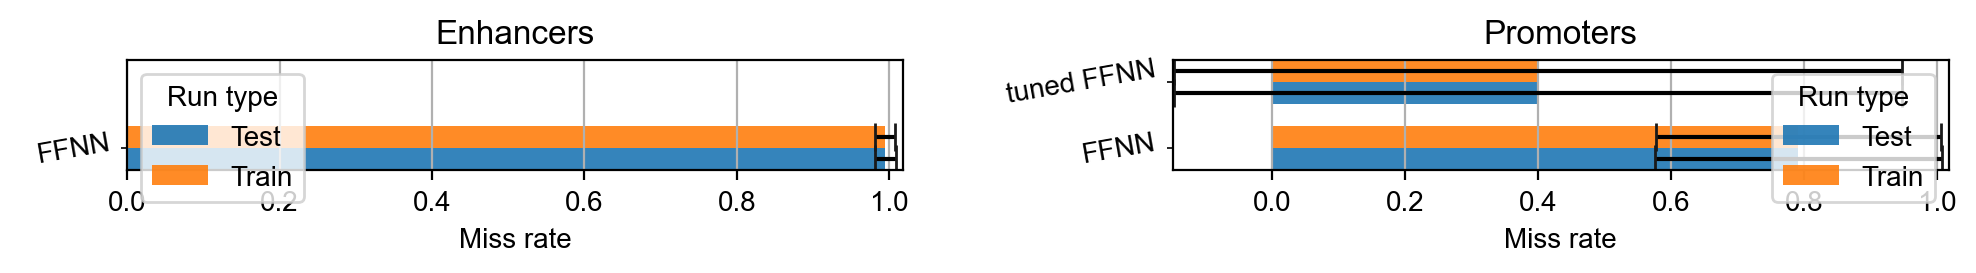

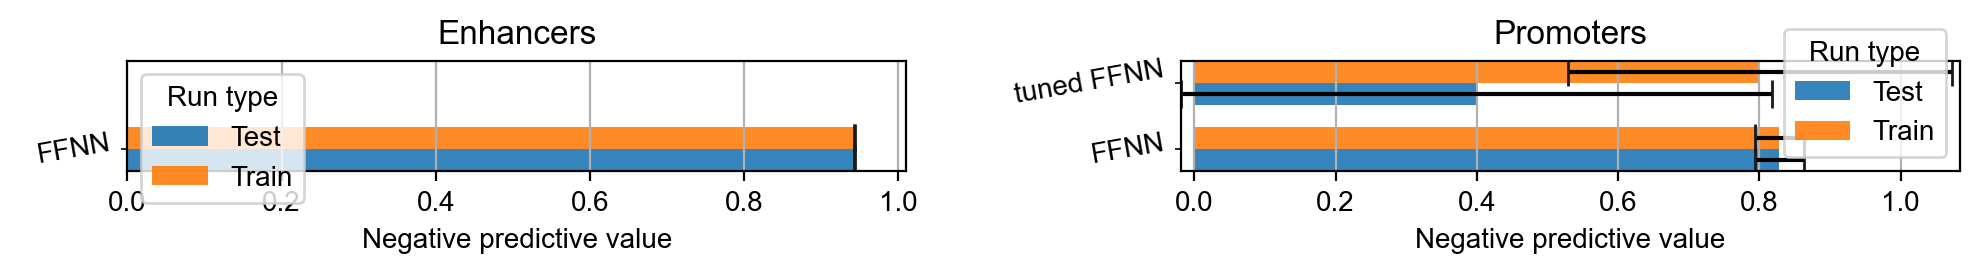

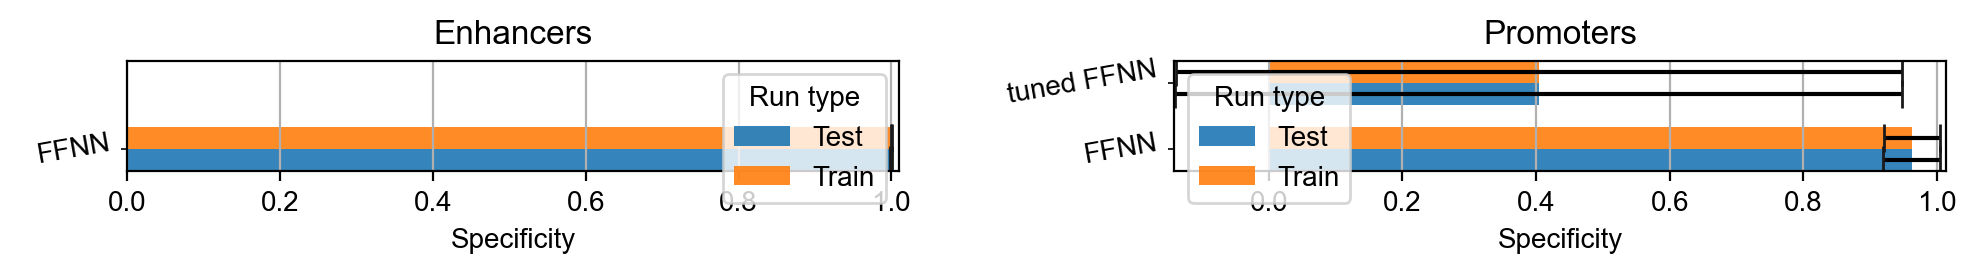

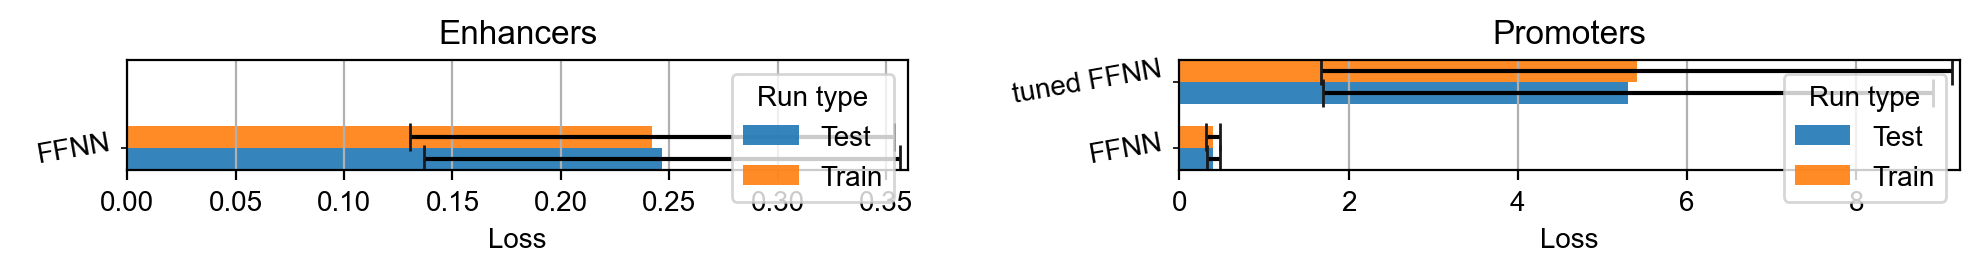

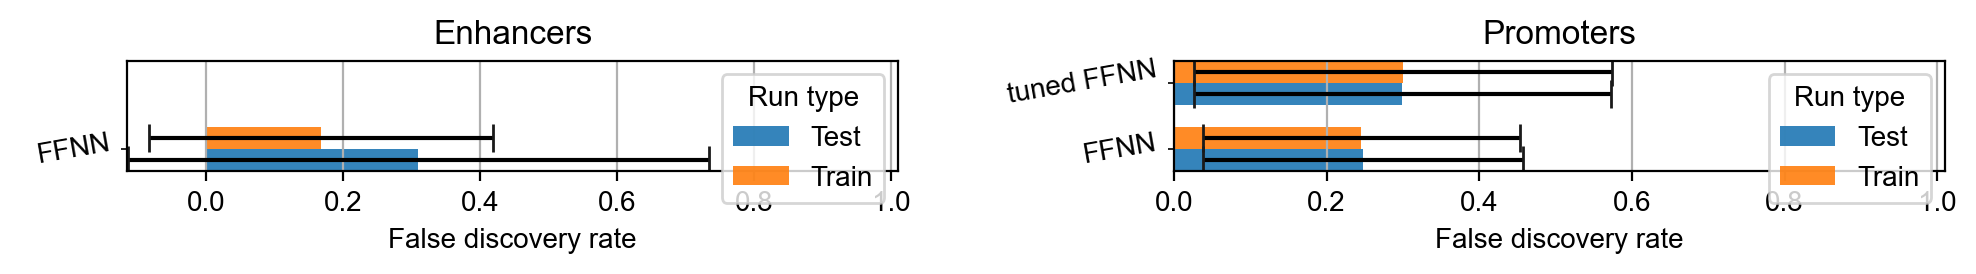

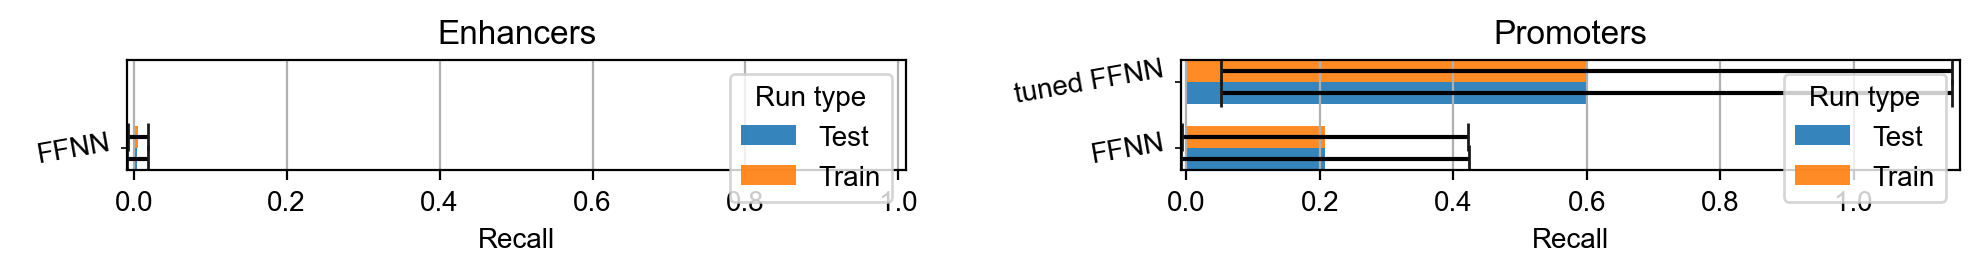

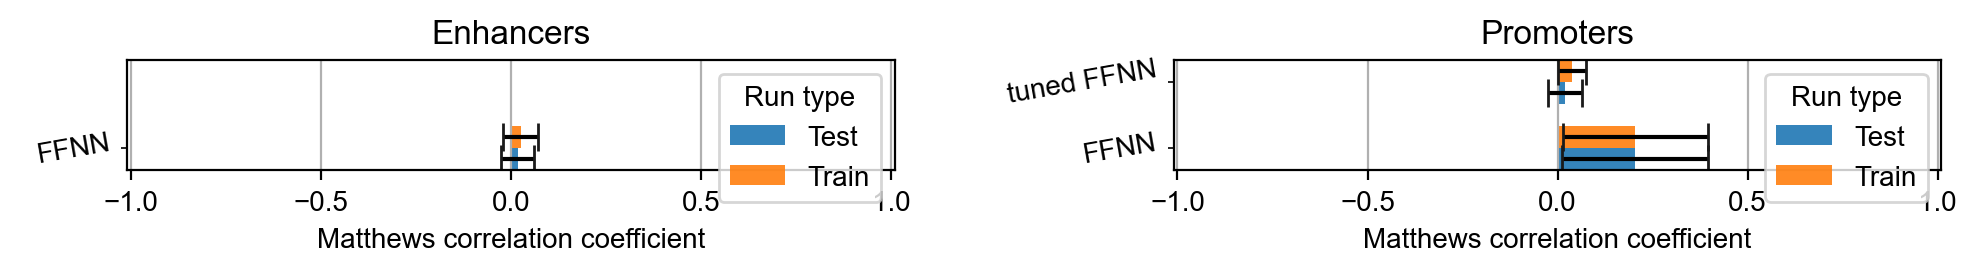

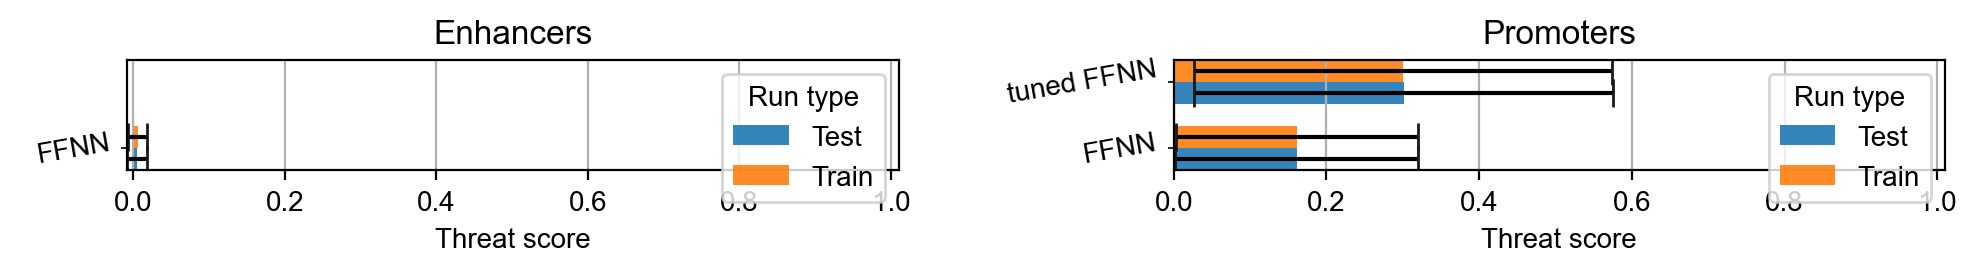

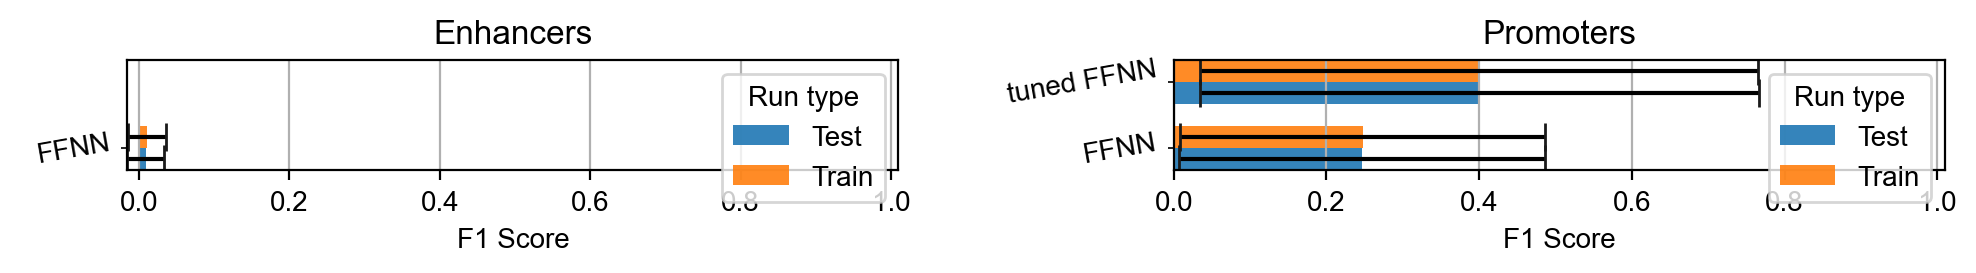

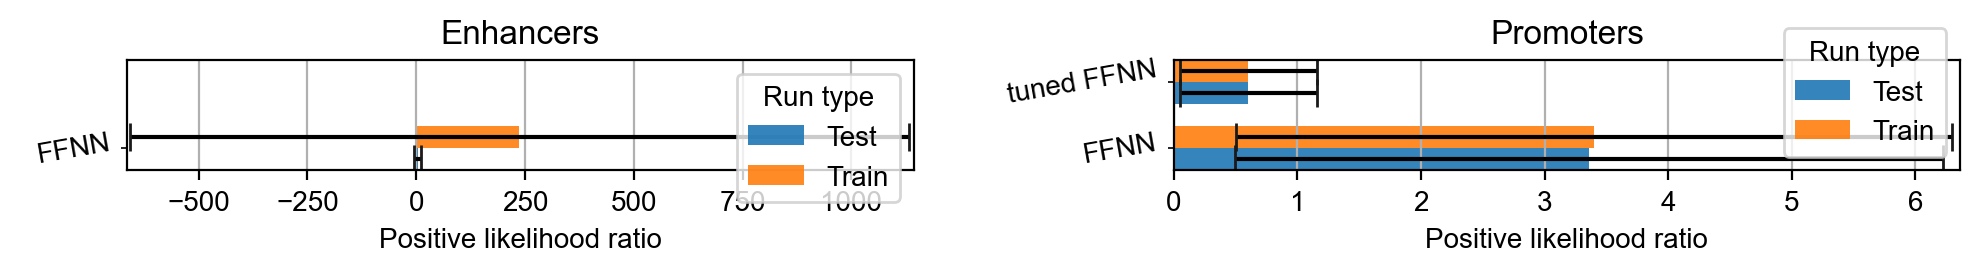

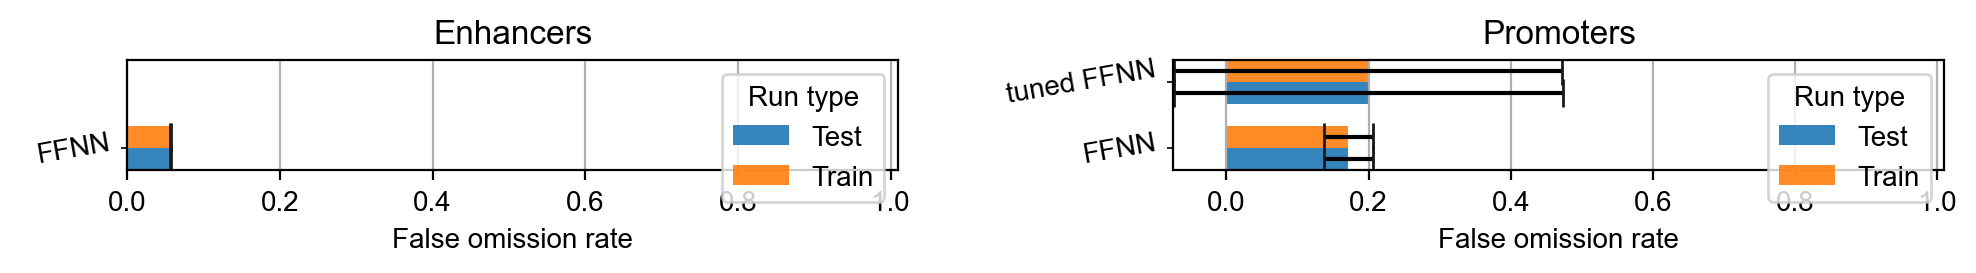

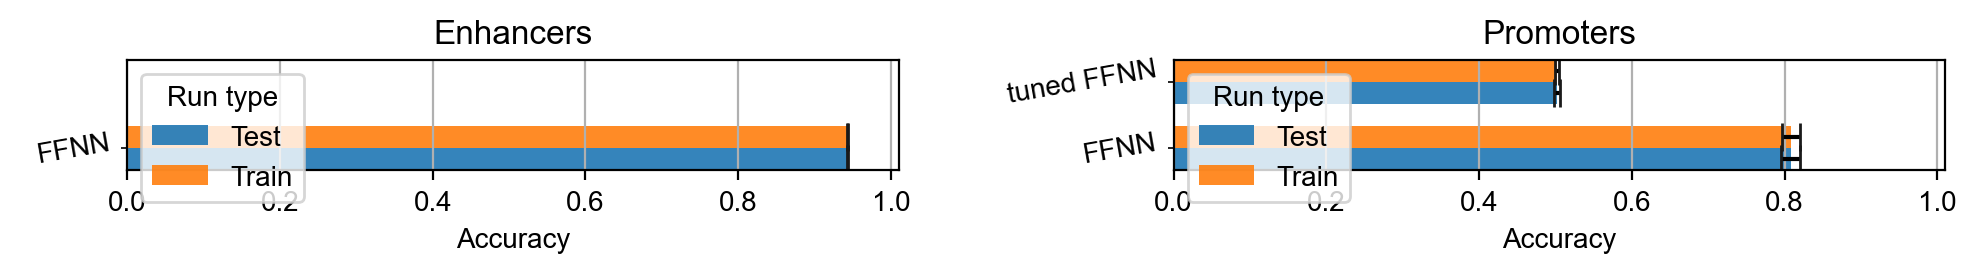

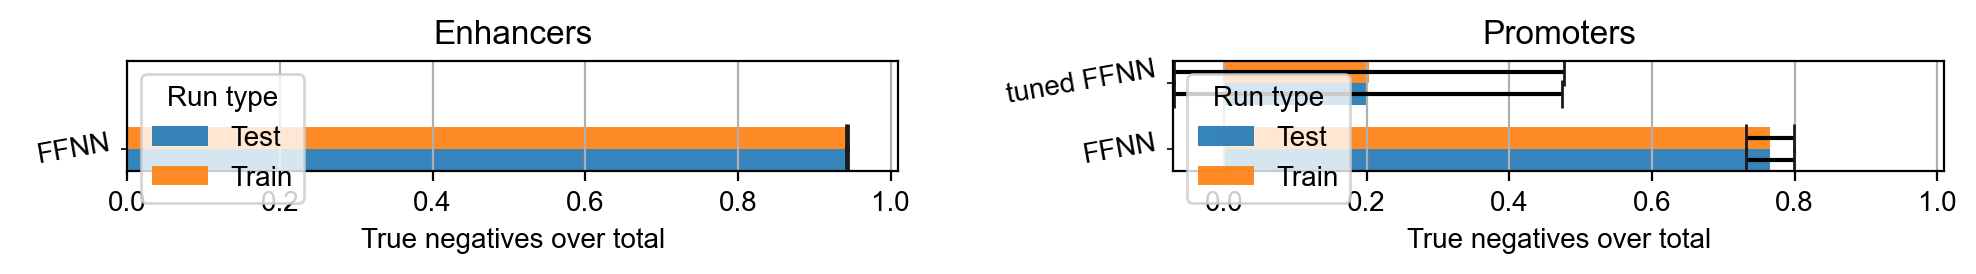

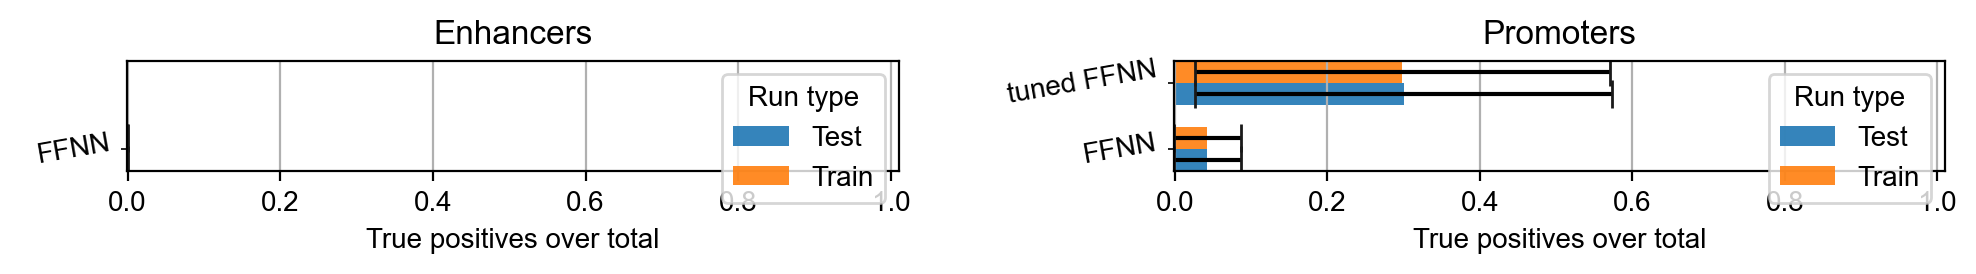

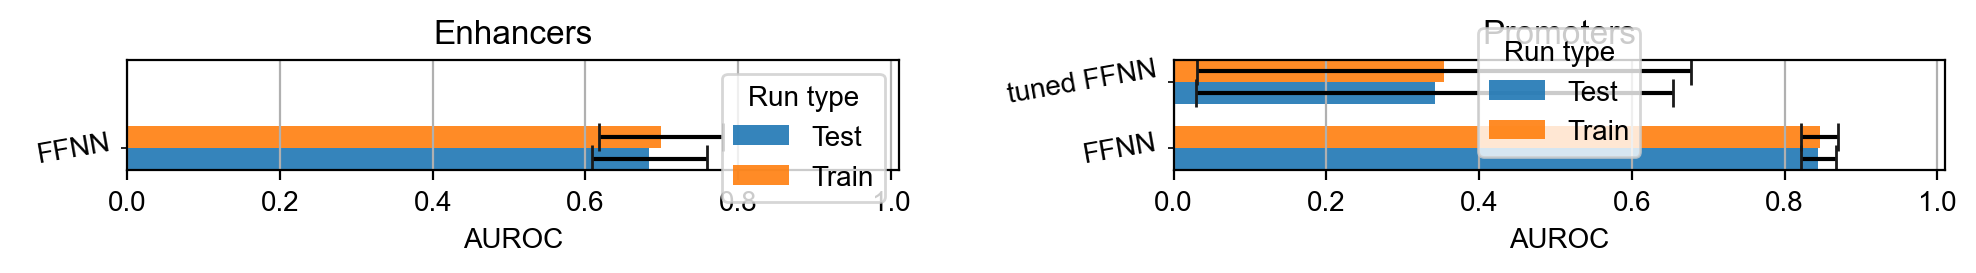

In [67]:
from barplots import barplots

barplots(
    all_ffnn_classification_performance.drop(columns=["holdout_number"]),
    groupby=["task", "model_name", "run_type"],
    orientation="horizontal",
    height=5,
    subplots=True,
    minor_rotation=10,
    show_legend = True
)